## Task 1

In [1]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimeDelta
from matplotlib import dates
from radiospectra.spectrogram2 import Spectrogram
from sunpy.net import attrs as a


In [2]:
%matplotlib notebook
# !wget https://data.lofar.ie/2017/09/02/bst/kbt/rcu357_1beam/20170902_103626_bst_00X.dat -P ./data

In [3]:
bstfile357 = "./data/20170902_103626_bst_00X.dat"
data357 = np.fromfile(bstfile357)
print("Number of data points:",data357.shape[0])
print("File size:",os.path.getsize(bstfile357))
print("Bitmode:",os.path.getsize(bstfile357)/data357.shape[0])


Number of data points: 14262288
File size: 114098304
Bitmode: 8.0


## Task 2

In [4]:
t_len357 = data357.shape[0]/488
print("Time samples:",t_len357 )
data357 = data357.reshape(-1,488)


Time samples: 29226.0


## Task 3

<IPython.core.display.Javascript object>


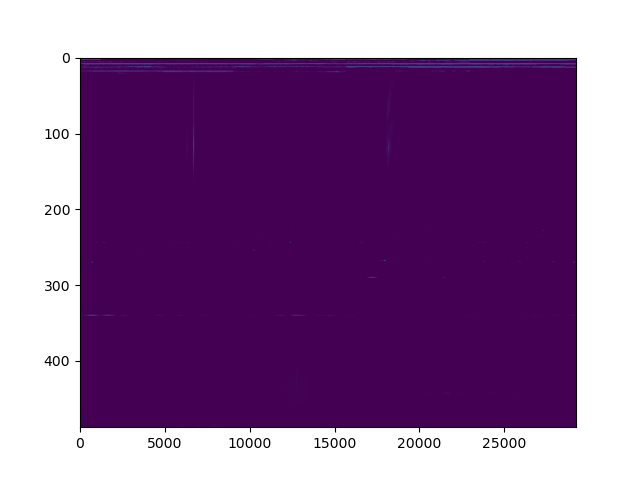

<IPython.core.display.Javascript object>


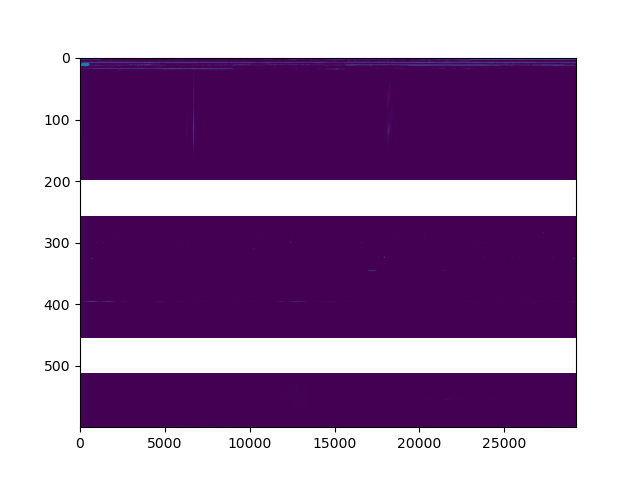

In [5]:
plt.imshow(data357.T, aspect="auto")
plt.figure()
plt.plot(np.log10(np.sum(data357,0)))

## Task 4

In [6]:
def sb_to_freq(sb, obs_mode):
	"""
	Converts LOFAR single station subbands to frequency
	Returns frequency as astropy.units.Quantity (MHz)
	Inputs: subband number, observation mode (3, 5 or 7)
	"""
	nyq_zone_dict = {3:1, 5:2, 7:3}
	nyq_zone = nyq_zone_dict[obs_mode]
	clock_dict = {3:200, 4:160, 5:200, 6:160, 7:200} #MHz
	clock = clock_dict[obs_mode]
	freq = (nyq_zone-1+sb/512)*(clock/2)
	return freq*u.MHz #MHz


In [7]:
data357 = data357.T
sbs = np.array((np.arange(54,454,2),np.arange(54,454,2),np.arange(54,230,2)), dtype=object)
blank_sbs = np.array((np.arange(454,512,2),np.arange(0,54,2),np.arange(454,512,2),np.arange(0,54,2)), dtype=object)
obs_mode = np.array((3,5,7))
blank_obs_mode = np.array((3,5,5,7))
freqs = np.array([sb_to_freq(sb,mode) for sb,mode in zip(sbs, obs_mode)], dtype=object)
blank_freqs = np.array([sb_to_freq(sb,mode) for sb,mode in zip(blank_sbs, blank_obs_mode)], dtype=object)

sbs=np.concatenate((sbs[0], blank_sbs[0], blank_sbs[1], sbs[1],
                            blank_sbs[2], blank_sbs[3], sbs[2]))

freqs=np.concatenate((freqs[0], blank_freqs[0], blank_freqs[1], freqs[1],
                            blank_freqs[2], blank_freqs[3], freqs[2]))


blank_data = np.zeros((freqs.shape[0],data357.shape[1]))
#1st 200 sbs mode 3, blank, next 200 sbs mode 5, blank, last 88 sbs mode 7
blank_data[:200,:] = data357[:200,:]
blank_len_0 = len(blank_freqs[0]) + len(blank_freqs[1])
blank_data[200 + blank_len_0:400 + blank_len_0,:] = data357[200:400,:]
blank_len_1 = len(blank_freqs[2]) + len(blank_freqs[3])
blank_data[400 + blank_len_0 + blank_len_1 :,:] = data357[400:,:]
data357 = blank_data

<IPython.core.display.Javascript object>


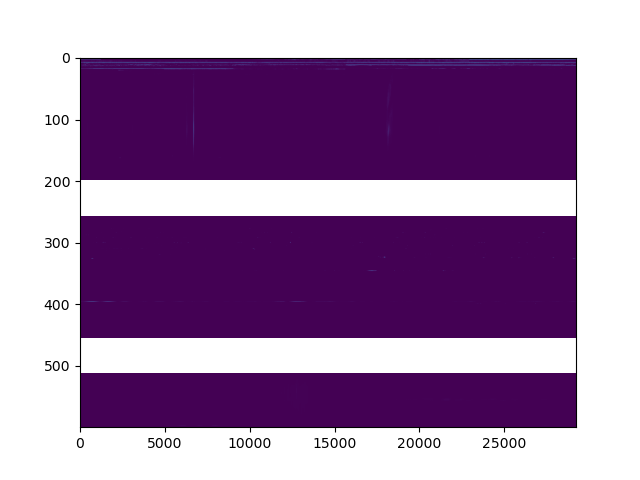

<IPython.core.display.Javascript object>


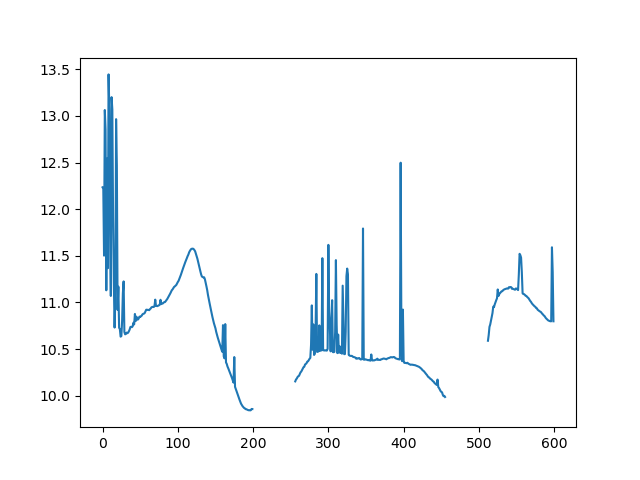

/tmp/ipykernel_19278/2614044502.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.sum(data357,1)))


In [9]:
mask = np.zeros(data357.shape)
mask[200:256,:] = 1	#1st 200 sbs are mode 3, 56 blank sbs
mask[456:512,:] = 1 #Next 200 sbs are mode 5, 56 blank sbs. Last 88 sbs are mode 7
data357 = np.ma.array(data357, mask=mask)

plt.figure()
plt.imshow(data357, aspect="auto")
plt.figure()
plt.plot(np.log10(np.sum(data357,1)))

In [10]:
obs_start357 = bstfile357[len(bstfile357)-27:len(bstfile357)-12]
obs_start357 = Time.strptime(obs_start357, "%Y%m%d_%H%M%S")
t_arr357 = np.arange(0,t_len357)
t_arr357 = t_arr357*TimeDelta(1*u.s, format='sec')
t_arr357 = obs_start357+t_arr357


<IPython.core.display.Javascript object>


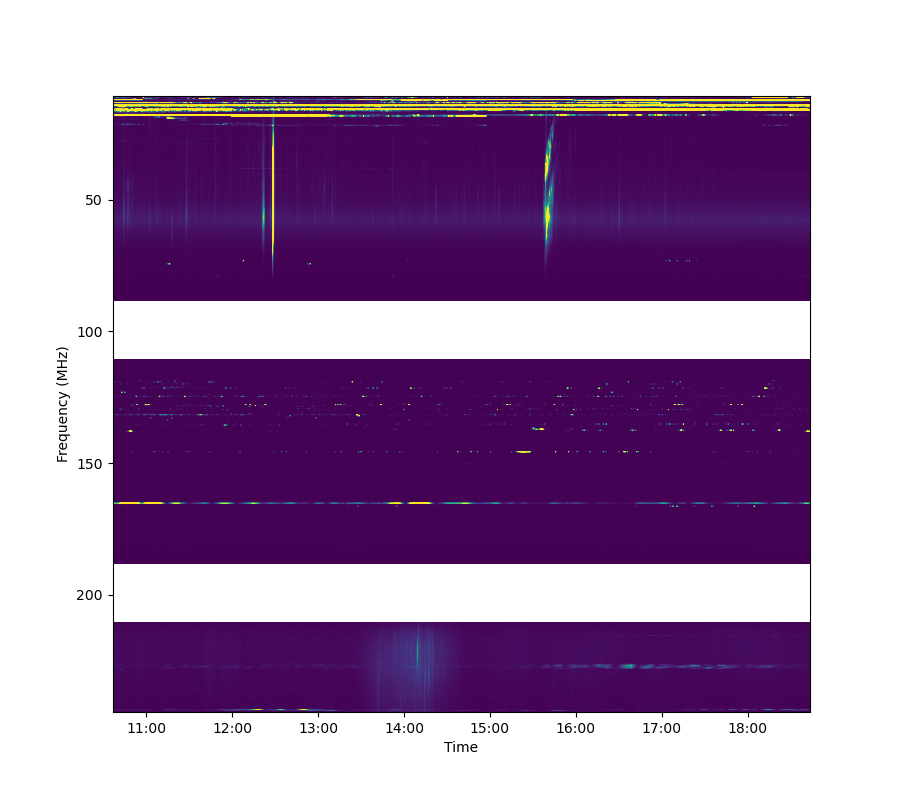

Text(0, 0.5, 'Frequency (MHz)')

In [11]:
fig, ax = plt.subplots(figsize=(9,8))
ax.imshow(data357, aspect="auto", extent=[t_arr357[0].plot_date, t_arr357[-1].plot_date, freqs.value[-1], freqs.value[0]],
         vmin = np.percentile(data357, 1), vmax = np.percentile(data357, 99))
ax.xaxis_date()
date_format = dates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Frequency (MHz)")

## Task 5

<IPython.core.display.Javascript object>


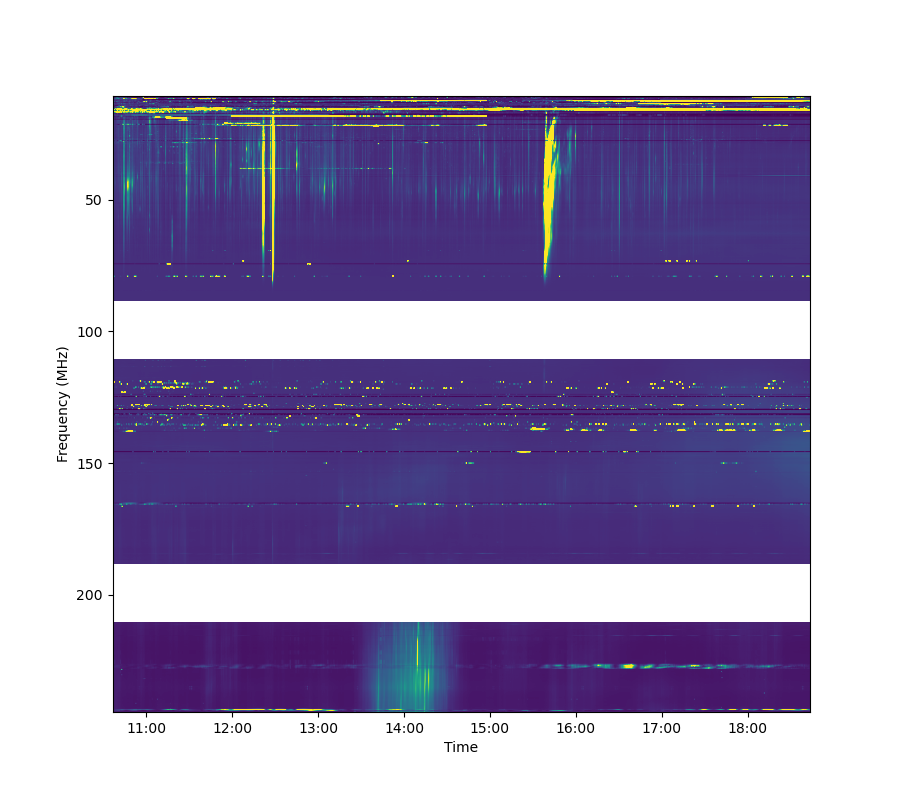

Text(0, 0.5, 'Frequency (MHz)')

In [12]:
data357 = (data357.T/np.mean(data357[:,10:20], axis=1)).T
fig, ax = plt.subplots(figsize=(9,8))
ax.imshow(data357, aspect="auto", extent=[t_arr357[0].plot_date, t_arr357[-1].plot_date, freqs.value[-1], freqs.value[0]],
         vmin = np.percentile(data357, 1), vmax = np.percentile(data357, 99))
ax.xaxis_date()
date_format = dates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Frequency (MHz)")

## Task 6 

<IPython.core.display.Javascript object>


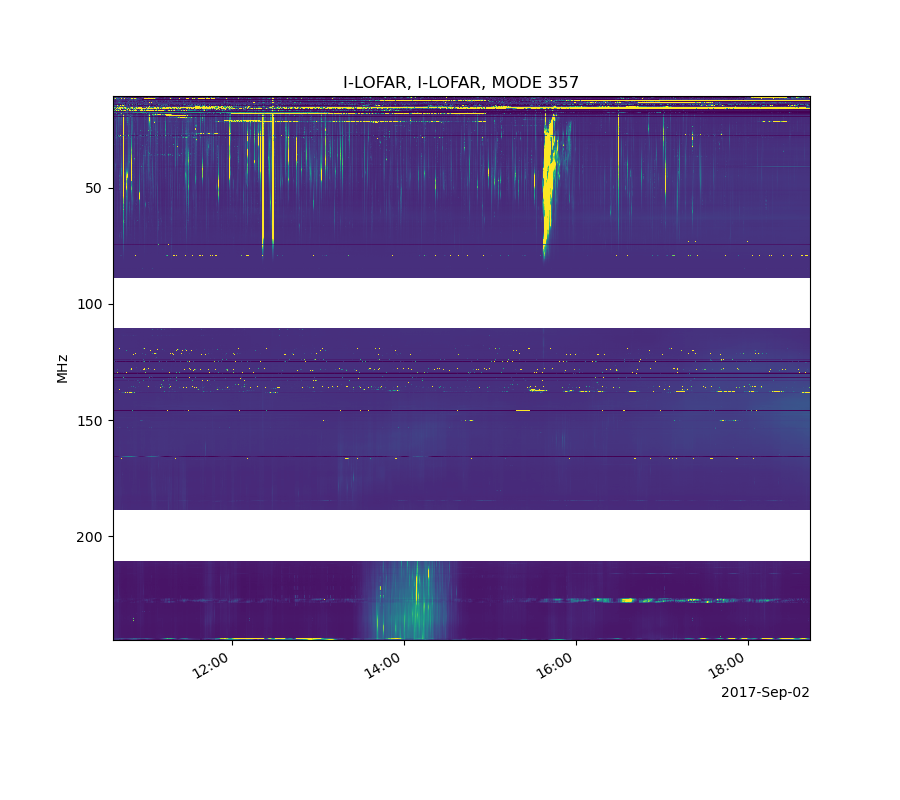

In [13]:
ilofar_meta = {
    'observatory': 'I-LOFAR',
    'instrument': 'I-LOFAR',
    'detector': 'Mode 357',
    'freqs': freqs,
    'times': t_arr357,
    'wavelength': a.Wavelength(freqs[0], freqs[-1]),
    'start_time': t_arr357[0],
    'end_time': t_arr357[-1]
}
ilofar_spec = Spectrogram(data357, ilofar_meta)
fig, ax = plt.subplots(figsize=(9,8))
ilofar_spec.plot(axes=ax, vmin = np.percentile(data357, 1), vmax = np.percentile(data357, 99))
plt.gca().invert_yaxis()

## Task 7

In [14]:
zoom_f = [10,90]*u.MHz
zoom_t = Time(('2017-09-02T15:30:00', '2017-09-02T15:50:00'), format='isot')

f0 = np.where(np.abs((freqs - zoom_f[0])) == np.min(np.abs((freqs - zoom_f[0]))))[0][0]
f1 = np.where(np.abs((freqs - zoom_f[1])) == np.min(np.abs((freqs - zoom_f[1]))))[0][0]

t0 = np.where(np.abs((t_arr357 - zoom_t[0]).sec) == np.min(np.abs((t_arr357 - zoom_t[0]).sec)))[0][0]
t1 = np.where(np.abs((t_arr357 - zoom_t[1]).sec) == np.min(np.abs((t_arr357 - zoom_t[1]).sec)))[0][0]

data_zoom = data357[f0:f1, t0:t1]

<IPython.core.display.Javascript object>


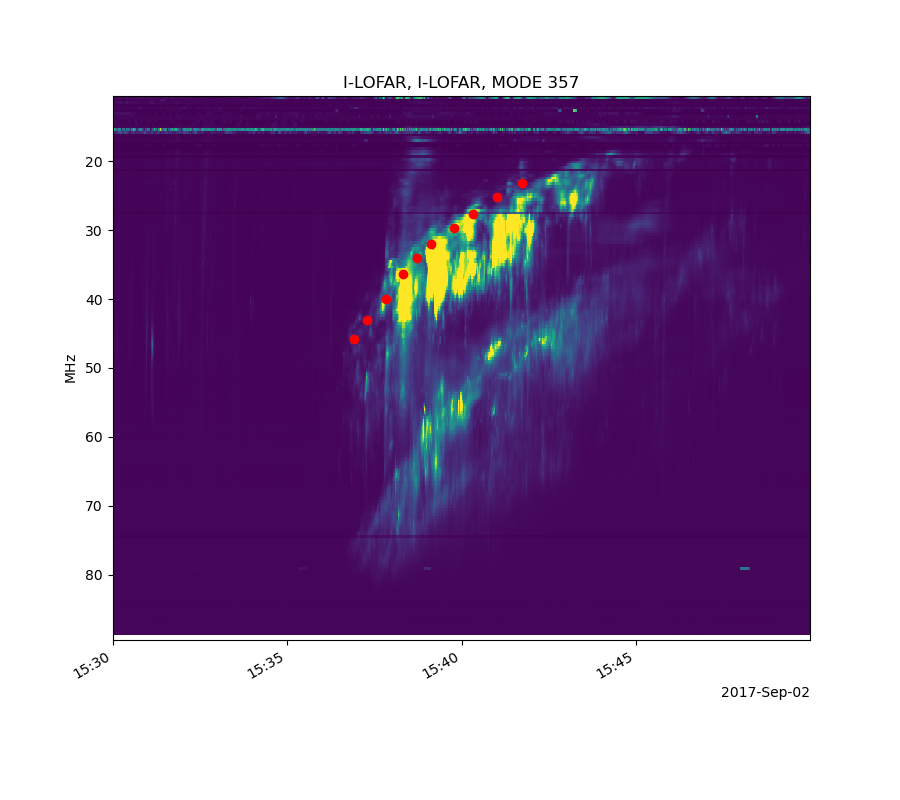

In [15]:
def onclick(event):
    global ix
    ix= event.xdata
    global iy
    iy=event.ydata
    global x_coords
    x_coords.append(ix)
    global y_coords
    y_coords.append(iy)
    ax.plot(ix, iy, 'o', color='r')
    fig.canvas.draw()
    # Disconnect after 10 clicks
    if len(x_coords) == 10:
        fig.canvas.mpl_disconnect(cid)
        
    return

ilofar_zoom_meta = {
    'observatory': 'I-LOFAR',
    'instrument': 'I-LOFAR',
    'detector': 'Mode 357',
    'freqs': freqs[f0:f1],
    'times': t_arr357[t0:t1],
    'wavelength': a.Wavelength(freqs[f0], freqs[f1]),
    'start_time': t_arr357[t0],
    'end_time': t_arr357[t1]
}
ilofar_zoom_spec = Spectrogram(data_zoom, ilofar_zoom_meta)

fig, ax = plt.subplots(figsize=(9,8))
ilofar_zoom_spec.plot(axes=ax, vmin = np.percentile(data_zoom, 1), vmax = np.percentile(data_zoom, 99))
# plt.xlim(t_arr357[t0].plot_date, t_arr357[t1].plot_date)
# plt.ylim(freqs[f0], freqs[f1])
plt.gca().invert_yaxis()
x_coords=[]
y_coords=[]
cid = fig.canvas.mpl_connect('button_press_event', onclick)


In [ ]:
# def onclick(event):
#     global ix
#     ix= event.xdata
#     global iy
#     iy=event.ydata
#     global x_coords
#     x_coords.append(ix)
#     global y_coords
#     y_coords.append(iy)
#     plt.plot(ix, iy, 'o', color='r')
#     fig.canvas.draw()
#     # Disconnect after 10 clicks
#     if len(x_coords) == 10:
#         fig.canvas.mpl_disconnect(cid)

#     return

# fig, ax = plt.subplots(figsize=(9,8))
# ax.imshow(data_zoom, aspect="auto", 
#           extent=[t_arr357[t0].plot_date, t_arr357[t1].plot_date, freqs.value[f1], freqs.value[f0]],
#           vmin = np.percentile(data_zoom, 1), vmax = np.percentile(data_zoom, 99))
# ax.xaxis_date()
# date_format = dates.DateFormatter("%H:%M")
# ax.xaxis.set_major_formatter(date_format)
# plt.xlabel("Time")
# plt.ylabel("Frequency (MHz)")

# x_coords=[]
# y_coords=[]
# cid = fig.canvas.mpl_connect('button_press_event', onclick)


In [16]:
x_coords = Time(x_coords, format = 'plot_date')
y_coords = y_coords*u.MHz
x_coords, y_coords

(<Time object: scale='utc' format='plot_date' value=[17411.65064613 17411.65090477 17411.65128279 17411.65162102
  17411.65189956 17411.6521781  17411.6526357  17411.65301372
  17411.65349122 17411.65398862]>,
 <Quantity [45.77426117, 43.01834435, 39.97233102, 36.34612468, 34.02535262,
            31.99467707, 29.67390501, 27.64322946, 25.17740915, 23.1467336 ] MHz>)

## Extra

In [ ]:
bstfile = "./data/20190415_084119_bst_00X.dat"
data = np.fromfile(bstfile)
print("Number of data points:",data.shape[0])
print("File size:",os.path.getsize(bstfile))
print("Bitmode:",os.path.getsize(bstfile)/data.shape[0])

#bitmode is 8 therefore 488 subbands (not always full of data though)
t_len = data.shape[0]/488
print("Time samples:",t_len )

In [ ]:
data = data.reshape(-1,488)
data = data[:,:400]
# of data.reshape(data.shape[0]//488,488)

In [ ]:
plt.imshow(data.T, aspect="auto")
plt.figure()
plt.plot(np.log10(np.sum(data,0)))

In [ ]:
sbs = np.arange(51,450) #found from observing script
freqs = sb_to_freq(sbs, obs_mode=3)
obs_start = bstfile[len(bstfile)-27:len(bstfile)-12]
obs_start = Time.strptime(obs_start, "%Y%m%d_%H%M%S")
obs_len  = TimeDelta(data.shape[0]*u.s, format='sec')# timedelta(seconds = data.shape[0])
obs_end = obs_start + obs_len
t_lims = [obs_start.plot_date, obs_end.plot_date]

#you only really need start and end time for imshow but we'll do a full array anyway
t_arr = np.arange(0,t_len)
t_arr = t_arr*TimeDelta(1*u.s, format='sec')
t_arr = obs_start+t_arr
t_arr = t_arr.plot_date

In [ ]:
fig, ax = plt.subplots()
ax.imshow(data.T, aspect="auto", extent=[t_arr[0], t_arr[-1], freqs.value[-1], freqs.value[0]],
         vmin = np.percentile(data.T, 1), vmax = np.percentile(data.T, 99))
ax.xaxis_date()
date_format = dates.DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Frequency (MHz)")

In [ ]:
data = data/np.mean(data[10:20], axis=0)
fig, ax = plt.subplots()
ax.imshow(data.T, aspect="auto", extent=[t_arr[0], t_arr[-1], freqs.value[-1], freqs.value[0]],
         vmin = np.percentile(data.T, 1), vmax = np.percentile(data.T, 99))
ax.xaxis_date()
date_format = dates.DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Frequency (MHz)")

## Radiospectra

In [ ]:
bstfile357 = "./data/20170902_103626_bst_00X.dat" #"data/modea/20190612_133144_bst_00X.dat"
data357 = np.fromfile(bstfile357)
t_len357 = data357.shape[0]/488
data357 = data357.reshape(-1,488)
data357 = data357.T


obs_start357 = bstfile357[len(bstfile357)-27:len(bstfile357)-12]
obs_start357 = Time.strptime(obs_start357, "%Y%m%d_%H%M%S")
t_arr357 = np.arange(0,t_len357)
t_arr357 = t_arr357*TimeDelta(1*u.s, format='sec')
t_arr357 = obs_start357+t_arr357

sbs = np.array((np.arange(54,454,2),np.arange(54,454,2),np.arange(54,230,2)), dtype=object)
blank_sbs = np.array((np.arange(454,512,2),np.arange(0,54,2),np.arange(454,512,2),np.arange(0,54,2)), dtype=object)
obs_mode = np.array((3,5,7))
blank_obs_mode = np.array((3,5,5,7))
freqs = np.array([sb_to_freq(sb,mode) for sb,mode in zip(sbs, obs_mode)], dtype=object)
blank_freqs = np.array([sb_to_freq(sb,mode) for sb,mode in zip(blank_sbs, blank_obs_mode)], dtype=object)

sbs=np.concatenate((sbs[0], blank_sbs[0], blank_sbs[1], sbs[1],
                            blank_sbs[2], blank_sbs[3], sbs[2]))

freqs=np.concatenate((freqs[0], blank_freqs[0], blank_freqs[1], freqs[1],
                            blank_freqs[2], blank_freqs[3], freqs[2]))


blank_data = np.zeros((freqs.shape[0],data357.shape[1]))
#1st 200 sbs mode 3, blank, next 200 sbs mode 5, blank, last 88 sbs mode 7
blank_data[:200,:] = data357[:200,:]
blank_len_0 = len(blank_freqs[0]) + len(blank_freqs[1])
blank_data[200 + blank_len_0:400 + blank_len_0,:] = data357[200:400,:]
blank_len_1 = len(blank_freqs[2]) + len(blank_freqs[3])
blank_data[400 + blank_len_0 + blank_len_1 :,:] = data357[400:,:]
data357 = blank_data

mask = np.zeros(data357.shape)
mask[200:256,:] = 1	#1st 200 sbs are mode 3, 56 blank sbs
mask[456:512,:] = 1 #Next 200 sbs are mode 5, 56 blank sbs. Last 88 sbs are mode 7
data357 = np.ma.array(data357, mask=mask)

data357 = (data357.T/np.mean(data357[:,10:20], axis=1)).T

In [ ]:
ilofar_meta = {
    'observatory': 'I-LOFAR',
    'instrument': 'I-LOFAR',
    'detector': 'Mode 357',
    'freqs': freqs,
    'times': t_arr357,
    'wavelength': a.Wavelength(freqs[0], freqs[-1]),
    'start_time': t_arr357[0],
    'end_time': t_arr357[-1]
}
ilofar_spec = Spectrogram(data357, ilofar_meta)
fig, ax = plt.subplots(figsize=(9,8))
ilofar_spec.plot(axes=ax, vmin = np.percentile(data357, 1), vmax = np.percentile(data357, 99))
plt.gca().invert_yaxis()

In [ ]:
def onclick(event):
    global ix
    ix= event.xdata
    global iy
    iy=event.ydata
    global x_coords
    x_coords.append(ix)
    global y_coords
    y_coords.append(iy)
    ax.plot(ix, iy, 'o', color='r')
    fig.canvas.draw()
    # Disconnect after 10 clicks
    if len(x_coords) == 10:
        fig.canvas.mpl_disconnect(cid)
        
    return

ilofar_zoom_meta = {
    'observatory': 'I-LOFAR',
    'instrument': 'I-LOFAR',
    'detector': 'Mode 357',
    'freqs': freqs[f0:f1],
    'times': t_arr357[t0:t1],
    'wavelength': a.Wavelength(freqs[f0], freqs[f1]),
    'start_time': t_arr357[t0],
    'end_time': t_arr357[t1]
}
ilofar_zoom_spec = Spectrogram(data_zoom, ilofar_zoom_meta)

fig, ax = plt.subplots(figsize=(9,8))
ilofar_zoom_spec.plot(axes=ax, vmin = np.percentile(data_zoom, 1), vmax = np.percentile(data_zoom, 99))
# plt.xlim(t_arr357[t0].plot_date, t_arr357[t1].plot_date)
# plt.ylim(freqs[f0], freqs[f1])
plt.gca().invert_yaxis()
x_coords=[]
y_coords=[]
cid = fig.canvas.mpl_connect('button_press_event', onclick)


In [ ]:
x_coords = Time(x_coords, format = 'plot_date')
y_coords = y_coords*u.MHz
print(x_coords.isot, y_coords)